<a href="https://colab.research.google.com/github/kaleetock/clusters/blob/main/Fig10Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#@title Installs and Imports
%%capture
!pip install astropy
!pip install astroquery
import astroquery.gaia
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5
from astropy.coordinates import Angle
from astroquery.gaia import Gaia
from google.colab import drive
from astroquery.vizier import Vizier
import math
import bokeh.plotting as bk
import matplotlib as mpl
from bokeh.models import Range1d, Label
from bokeh.models import Title
from bokeh.layouts import row, gridplot
import numpy as np
import os
import re
import json
import requests

from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SquaredStretch
from astropy.wcs import WCS
from IPython.display import Javascript

drive.mount("/content/drive")

from bokeh.core.properties import Instance, String
from bokeh.io import show
from bokeh.models import ColumnDataSource, LayoutDOM
from bokeh.util.compiler import TypeScript

TS_CODE = """
// This custom model wraps one part of the third-party vis.js library:
//
//     http://visjs.org/index.html
//
// Making it easy to hook up python data analytics tools (NumPy, SciPy,
// Pandas, etc.) to web presentations using the Bokeh server.

import {LayoutDOM, LayoutDOMView} from "models/layouts/layout_dom"
import {ColumnDataSource} from "models/sources/column_data_source"
import {LayoutItem} from "core/layout"
import * as p from "core/properties"

declare namespace vis {
  class Graph3d {
    constructor(el: HTMLElement, data: object, OPTIONS: object)
    setData(data: vis.DataSet): void
  }

  class DataSet {
    add(data: unknown): void
  }
}

// This defines some default options for the Graph3d feature of vis.js
// See: http://visjs.org/graph3d_examples.html for more details.
const OPTIONS = {
  width: '600px',
  height: '600px',
  style: 'surface',
  showPerspective: true,
  showGrid: true,
  keepAspectRatio: true,
  verticalRatio: 1.0,
  legendLabel: 'stuff',
  cameraPosition: {
    horizontal: -0.35,
    vertical: 0.22,
    distance: 1.8,
  },
}
// To create custom model extensions that will render on to the HTML canvas
// or into the DOM, we must create a View subclass for the model.
//
// In this case we will subclass from the existing BokehJS ``LayoutDOMView``
export class Surface3dView extends LayoutDOMView {
  model: Surface3d

  private _graph: vis.Graph3d

  initialize(): void {
    super.initialize()

    const url = "https://cdnjs.cloudflare.com/ajax/libs/vis/4.16.1/vis.min.js"
    const script = document.createElement("script")
    script.onload = () => this._init()
    script.async = false
    script.src = url
    document.head.appendChild(script)
  }

  private _init(): void {
    // Create a new Graph3s using the vis.js API. This assumes the vis.js has
    // already been loaded (e.g. in a custom app template). In the future Bokeh
    // models will be able to specify and load external scripts automatically.
    //
    // BokehJS Views create <div> elements by default, accessible as this.el.
    // Many Bokeh views ignore this default <div>, and instead do things like
    // draw to the HTML canvas. In this case though, we use the <div> to attach
    // a Graph3d to the DOM.
    this._graph = new vis.Graph3d(this.el, this.get_data(), OPTIONS)

    // Set a listener so that when the Bokeh data source has a change
    // event, we can process the new data
    this.connect(this.model.data_source.change, () => {
      this._graph.setData(this.get_data())
    })
  }

  // This is the callback executed when the Bokeh data has an change. Its basic
  // function is to adapt the Bokeh data source to the vis.js DataSet format.
  get_data(): vis.DataSet {
    const data = new vis.DataSet()
    const source = this.model.data_source
    for (let i = 0; i < source.get_length()!; i++) {
      data.add({
        x: source.data[this.model.x][i],
        y: source.data[this.model.y][i],
        z: source.data[this.model.z][i],
      })
    }
    return data
  }

  get child_models(): LayoutDOM[] {
    return []
  }

  _update_layout(): void {
    this.layout = new LayoutItem()
    this.layout.set_sizing(this.box_sizing())
  }
}

// We must also create a corresponding JavaScript BokehJS model subclass to
// correspond to the python Bokeh model subclass. In this case, since we want
// an element that can position itself in the DOM according to a Bokeh layout,
// we subclass from ``LayoutDOM``
export namespace Surface3d {
  export type Attrs = p.AttrsOf<Props>

  export type Props = LayoutDOM.Props & {
    x: p.Property<string>
    y: p.Property<string>
    z: p.Property<string>
    data_source: p.Property<ColumnDataSource>
  }
}

export interface Surface3d extends Surface3d.Attrs {}

export class Surface3d extends LayoutDOM {
  properties: Surface3d.Props
  __view_type__: Surface3dView

  constructor(attrs?: Partial<Surface3d.Attrs>) {
    super(attrs)
  }

  // The ``__name__`` class attribute should generally match exactly the name
  // of the corresponding Python class. Note that if using TypeScript, this
  // will be automatically filled in during compilation, so except in some
  // special cases, this shouldn't be generally included manually, to avoid
  // typos, which would prohibit serialization/deserialization of this model.
  static __name__ = "Surface3d"

  static init_Surface3d() {
    // This is usually boilerplate. In some cases there may not be a view.
    this.prototype.default_view = Surface3dView

    // The @define block adds corresponding "properties" to the JS model. These
    // should basically line up 1-1 with the Python model class. Most property
    // types have counterparts, e.g. ``bokeh.core.properties.String`` will be
    // ``String`` in the JS implementatin. Where the JS type system is not yet
    // as rich, you can use ``p.Any`` as a "wildcard" property type.
    this.define<Surface3d.Props>(({String, Ref}) => ({
      x:            [ String ],
      y:            [ String ],
      z:            [ String ],
      data_source:  [ Ref(ColumnDataSource) ],
    }))
  }
}
"""

# This custom extension model will have a DOM view that should layout-able in
# Bokeh layouts, so use ``LayoutDOM`` as the base class. If you wanted to create
# a custom tool, you could inherit from ``Tool``, or from ``Glyph`` if you
# wanted to create a custom glyph, etc.
class Surface3d(LayoutDOM):

    # The special class attribute ``__implementation__`` should contain a string
    # of JavaScript code that implements the browser side of the extension model.
    __implementation__ = TypeScript(TS_CODE)

    # Below are all the "properties" for this model. Bokeh properties are
    # class attributes that define the fields (and their types) that can be
    # communicated automatically between Python and the browser. Properties
    # also support type validation. More information about properties in
    # can be found here:
    #
    #    https://docs.bokeh.org/en/latest/docs/reference/core/properties.html#bokeh-core-properties

    # This is a Bokeh ColumnDataSource that can be updated in the Bokeh
    # server by Python code
    data_source = Instance(ColumnDataSource)

    # The vis.js library that we are wrapping expects data for x, y, and z.
    # The data will actually be stored in the ColumnDataSource, but these
    # properties let us specify the *name* of the column that should be
    # used for each field.
    x = String

    y = String

    z = String


In [3]:
target, ra_deg, dec_deg = "NGC3201", 154.415222388, -46.4561360212
p = "/content/drive/MyDrive/The Clusterminators"
img_path = os.path.join(p, 'Images/LCOGTOHSInStAR/2021_Clusters/NGC3201/')
images = {"V": os.path.join(img_path, 'NGC3201_V_2459267d1363186929_2021d02d21T15d08d07d070_1a0551449_300d237_kb24_OHSInStAR.fit'),
          "ip": os.path.join(img_path, 'NGC3201_ip_2459267d2642491790_2021d02d21T18d13d34d684_1a4900727_150d243_kb24_OHSInStAR.fit') }
catalog_urls = {"Terzan3": "http://www.astro.utoronto.ca/~cclement/cat/C1625m352",
                "NGC3201": "http://www.astro.utoronto.ca/~cclement/cat/C1015m461",
                "M92": "http://www.astro.utoronto.ca/~cclement/cat/C1715p432"       # Must add additional target catalogs manually
                }

phot_path = os.path.join(p, "photometry/Time_Series_Photometry_Files/NGC3201_psx_V") 
img = "/content/drive/MyDrive/2021 Astrophysics/Labs/Wk 13 Cluster Pulsar/SampleData/NGC3201_V_2459247d3940691710_2021d02d01T21d20d54d078_1a2063539_240d281_kb84_OHSInStAR.fit"


In [4]:
def find_fig10_phot(phot_path, stars, phot_file):
  files = [f for f in sorted(os.listdir(phot_path)) if os.path.isfile(os.path.join(phot_path, f))]
  for f in files:
    if f != phot_file:
      continue
    with open (os.path.join(phot_path,f), "r") as phot:
      for line in phot:
        ra, dec, px, py, cnts, err, u1, u2 = line.strip().split(",")
        ra = float(ra)
        dec = float(dec)
#        m = re.search("^154.3863432,-46.4291925,1602.9081", line)
#        if m:
#          print(f)
        for s in stars:
          name, sra, sdec = s["name"], s["ra"], s["dec"]
          if (abs(ra - sra) < 0.0005) and (abs(dec - sdec) < 0.0005):
            print(line.strip())
            print(f"Star Name {name}")


####################################################################

stars = [{"name": "23", "ra": 154.386, "dec": -46.425306}, {"name": "38", "ra": 154.380917, "dec": -46.428083}, {"name": "76", "ra": 154.380375, "dec": -46.423222}]

phot_file = "NGC3201_V_2459247d3940691710_2021d02d01T21d20d54d078_1a2063539_240d281_kb84_OHSInStAR.psx"
find_fig10_phot(phot_path, stars, phot_file)

154.3803840,-46.4232605,1565.3450,901.5863,40363.49,315.9283,6.314095e-06,4.153824e-06
Star Name 76
154.3860066,-46.4255095,1579.5896,926.3909,90200.72,392.6851,3.316372e-06,1.998483e-06
Star Name 23
154.3809740,-46.4281503,1596.4763,904.3826,39261.14,315.7867,4.354965e-06,3.642848e-06
Star Name 38


<IPython.core.display.Javascript object>

((3014, 2002),
 array([[501.7318 , 512.17224, 497.1795 , ..., 502.2045 , 481.05768,
         503.47668],
        [497.0483 , 535.2581 , 466.63446, ..., 507.35062, 505.58194,
         540.8163 ],
        [496.86652, 511.60147, 515.0817 , ..., 475.5422 , 493.76224,
         431.54996],
        ...,
        [489.06516, 474.7736 , 488.00272, ..., 428.4834 , 484.5932 ,
         464.92343],
        [504.98468, 474.6782 , 470.7635 , ..., 465.3087 , 498.8917 ,
         517.8019 ],
        [463.90494, 461.07864, 481.2862 , ..., 460.4856 , 473.06247,
         461.63486]], dtype=float32))

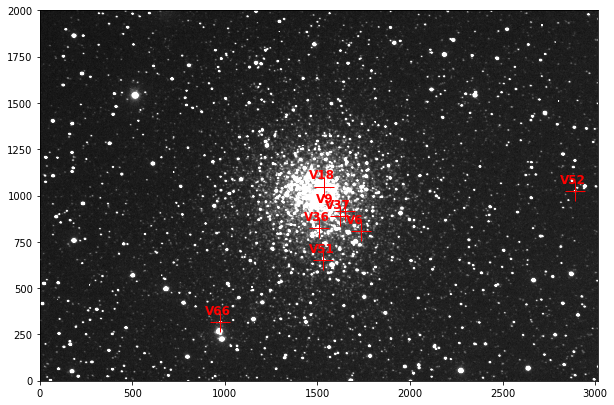

In [36]:
# Display functions

##########################################################

def display_image(img, stars):
  infits = fits.open(img)
  hdr = dict(infits[0].header)
  wrld = WCS(infits[0].header)
  fdims = wrld.pixel_shape
#  centerx, centery = fdims[0]/2, fdims[1]/2
#  centercoords = wrld.pixel_to_world(centerx,centery)
#  centerRA, centerDec = centercoords.ra.degree, centercoords.dec.degree
  image_data = infits[0].data
  norm = ImageNormalize(image_data, interval=ZScaleInterval(), stretch=SquaredStretch())
  fig = plt.figure(figsize=(21,14))
  ax = fig.add_subplot(111)
  plt.imshow(image_data, norm=norm, origin='lower', cmap='Greys_r', interpolation=None)

  for star in stars:
    starx, stary = star[0], star[1]
    ax.plot(starx, stary, marker='+',color='red', ms=20)

  starx, stary = stars[0][0], stars[0][1]
#  ax.text((starx+(fdims[0]/80)), (stary+(fdims[1]/80)), str(f"stars"), color = 'white', backgroundcolor='black', fontsize=16)

  return(fdims, image_data)

##########################################################

def label_coords(img, labels, show_nums):
  infits = fits.open(img)
  hdr = dict(infits[0].header)
  wrld = WCS(infits[0].header)
  fdims = wrld.pixel_shape
  image_data = infits[0].data
  norm = ImageNormalize(image_data, interval=ZScaleInterval(), stretch=SquaredStretch())
  fig = plt.figure(figsize=(10,7.5))
  ax = fig.add_subplot(111)
  plt.imshow(image_data, norm=norm, origin='lower', cmap='Greys_r', interpolation=None)

  for star in labels:
    name, ra, dec = star["name"], star["coords"][0], star["coords"][1]
    skystar = SkyCoord(ra, dec, frame='fk5', unit='deg')
    stary, starx = wrld.world_to_array_index(skystar)
    if (starx < 50 or starx > 2950 or stary < 50 or stary > 1950):
      print(f"{name} is outside the image FOV")
      continue
    if show_nums:
      offset_y, offset_x = fdims[0]/70, fdims[1]/25
      if name=="V9":
        offset_x *= 2
#     ax.text((starx-offset_x), (stary+offset_y), name, color = 'white', backgroundcolor='black', fontsize=12)
      ax.text((starx-offset_x), (stary+offset_y), name, color = 'red', fontsize=12,fontweight="bold")
    ax.plot(starx, stary, marker='+',color='red', ms=20)

  return(fdims, image_data)

##########################################################

def get_roi_data(fdims, starx, stary, image_data, x_roi, y_roi):
  x, y = int(starx), int(stary)
  x_extent, y_extent = 2*x_roi, 2*y_roi

  x_vals, y_vals, z_vals = [], [], []
  for j in range(len(image_data)):
    if j >= y-y_roi and j <= y+y_roi:
      row = image_data[j]
      for i in range(len(row)):
        if i >= x-x_roi and i <= x+x_roi:
          x_vals.append(i)
          y_vals.append(j)
          z_vals.append(image_data[j][i])

  return(x_vals, y_vals, z_vals)

###############################################################

def plot_psfs(image_data, fdims, starx, stary, x_roi, y_roi):
  x_vals, y_vals, z_vals = get_roi_data(fdims, starx, stary, image_data, x_roi, y_roi)
  source = ColumnDataSource(data=dict(x=x_vals, y=y_vals, z=z_vals))
  surface = Surface3d(x="x", y="y", z="z", data_source=source, width=600, height=600)
  print(f"target:")
  bk.show(surface)

###############################################################

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
bk.output_notebook()

img = "/content/drive/MyDrive/2021 Astrophysics/Labs/Wk 13 Cluster Pulsar/SampleData/NGC3201_V_2459247d3940691710_2021d02d01T21d20d54d078_1a2063539_240d281_kb84_OHSInStAR.fit"


updates = [{"name": "V6", "coords": (154.3587083,-46.4506389)}, 
           {"name": "V9", "coords": (154.3845000,-46.4368333)}, 
           {"name": "V18", "coords": (154.41408,	-46.41839)},
           {"name": "V36", "coords": (154.36265,	-46.41464)},
           {"name": "V37", "coords": (154.37793, -46.43212)},
           {"name": "V51", "coords": (154.32363,	-46.41839)}, 
           {"name": "V52", "coords": (154.4094664,-46.6328306)}, 
           {"name": "V66", "coords": (154.2462632,-46.3301159)}, ]


stars = [(1603, 928), (1565, 902), (1580, 926)]
x_roi, y_roi = 25, 25    

#fdims, image_data = display_image(img, stars)

label_coords(img, updates, True)

#plot_psfs(image_data, fdims, 1603, 928, x_roi, y_roi)



V53 is outside the image FOV
V54 is outside the image FOV
V60 is outside the image FOV
V61 is outside the image FOV
V62 is outside the image FOV
V63 is outside the image FOV
V64 is outside the image FOV
V68 is outside the image FOV
V69 is outside the image FOV
V85 is outside the image FOV
V86 is outside the image FOV
V87 is outside the image FOV
V88 is outside the image FOV
V89 is outside the image FOV
V91 is outside the image FOV
V93 is outside the image FOV
V94 is outside the image FOV
V95 is outside the image FOV
V96 is outside the image FOV


((3014, 2002),
 array([[501.7318 , 512.17224, 497.1795 , ..., 502.2045 , 481.05768,
         503.47668],
        [497.0483 , 535.2581 , 466.63446, ..., 507.35062, 505.58194,
         540.8163 ],
        [496.86652, 511.60147, 515.0817 , ..., 475.5422 , 493.76224,
         431.54996],
        ...,
        [489.06516, 474.7736 , 488.00272, ..., 428.4834 , 484.5932 ,
         464.92343],
        [504.98468, 474.6782 , 470.7635 , ..., 465.3087 , 498.8917 ,
         517.8019 ],
        [463.90494, 461.07864, 481.2862 , ..., 460.4856 , 473.06247,
         461.63486]], dtype=float32))

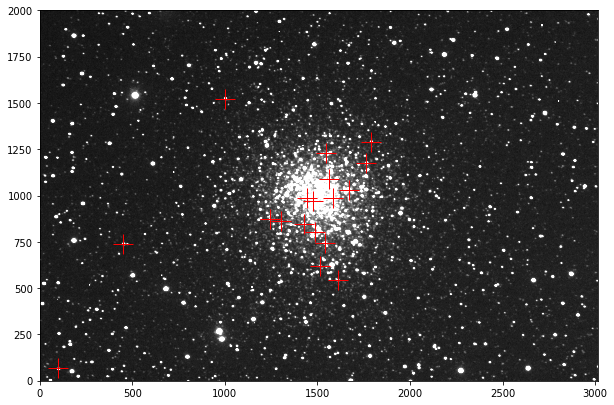

In [37]:
not_found = [{"name": "V12", "coords": (154.37096, -46.38217)},
  {"name": "V33", "coords": (154.42421, -46.42289)},
  {"name": "V34", "coords": (154.52283, -46.33394)},
  {"name": "V45", "coords": (154.45537, -46.42072)},
  {"name": "V50", "coords": (154.40042, -46.40389)},
  {"name": "V53", "coords": (154.05437, -46.617)},
  {"name": "V54", "coords": (154.67358, -46.6315)},
  {"name": "V60", "coords": (154.06462, -46.38781)},
  {"name": "V61", "coords": (153.95512, -46.36106)},
  {"name": "V62", "coords": (153.98229, -46.46536)},
  {"name": "V63", "coords": (154.00546, -46.39775)},
  {"name": "V64", "coords": (154.14908, -46.17533)},
  {"name": "V65", "coords": (154.18896, -46.19192)},
  {"name": "V68", "coords": (154.29404, -46.1795)},
  {"name": "V69", "coords": (154.31775, -46.13631)},
  {"name": "V70", "coords": (154.31637, -46.41514)},
  {"name": "V72", "coords": (154.34275, -46.24739)},
  {"name": "V74", "coords": (154.36729, -46.40178)},
  {"name": "V75", "coords": (154.37325, -46.37233)},
  {"name": "V77", "coords": (154.40054, -46.42669)},
  {"name": "V79", "coords": (154.40996, -46.43997)},
  {"name": "V81", "coords": (154.44379, -46.45481)},
  {"name": "V82", "coords": (154.47021, -46.45867)},
  {"name": "V85", "coords": (154.63271, -46.52328)},
  {"name": "V86", "coords": (154.65192, -46.49956)},
  {"name": "V87", "coords": (154.81312, -46.53553)},
  {"name": "V88", "coords": (154.50204, -46.11117)},
  {"name": "V89", "coords": (154.97325, -46.46667)},
  {"name": "V90", "coords": (154.39562, -46.40925)},
  {"name": "V91", "coords": (153.79712, -46.07869)},
  {"name": "V92", "coords": (154.34458, -46.41972)},
  {"name": "V93", "coords": (155.21312, -46.46767)},
  {"name": "V94", "coords": (153.2605, -45.89561)},
  {"name": "V95", "coords": (155.15762, -45.69442)},
  {"name": "V96", "coords": (153.2715, -46.53417)},
  {"name": "V97", "coords": (154.2985, -46.43083)},
  {"name": "V99", "coords": (154.3575, -46.41094)}]


label_coords(img, not_found, False)
